In [2]:
import pandas as pd
import numpy as np

# List of features to extract from the CSV
FEATURES = [
    'label',  # Label (CONFIRMED = 1, FALSE POSITIVE = 0, CANDIDATE)

    # Orbital and Transit Parameters
    'orbital_period',  # Orbital Period [days]
    'transit_duration',  # Transit Duration [hrs]
    'transit_duration_err1',  # Transit Duration Upper Unc. [hrs]
    'transit_duration_err2',  # Transit Duration Lower Unc. [hrs]
    'transit_depth',  # Transit Depth [ppm]
    'transit_depth_err1',  # Transit Depth Upper Unc. [ppm]
    'transit_depth_err2',  # Transit Depth Lower Unc. [ppm]
    
    # Planetary Properties
    'planet_radius',  # Planetary Radius [Earth radii]
    'planet_radius_err1',  # Planetary Radius Upper Unc.
    'planet_radius_err2',  # Planetary Radius Lower Unc.
    'equi_temp',  # Equilibrium temp
    
    # Stellar Properties
    'stellar_temp',  # Stellar Effective Temperature [K]
    'stellar_temp_err1',  # Stellar Effective Temperature Upper Unc.
    'stellar_temp_err2',  # Stellar Effective Temperature Lower Unc.
    'stellar_radius',  # Stellar Radius [Solar radii]
    'stellar_radius_err1',  # Stellar Radius Upper Unc.
    'stellar_radius_err2',  # Stellar Radius Lower Unc.
]

# Critical features that must be present for a row to be valid
CRITICAL_FEATURES = [
    'label',  # Must have a label
    'orbital_period',  # Orbital period is critical
    'transit_duration',  # Transit duration is critical
    'transit_depth',  # Transit depth is critical
]


def clean_data(df, missing_threshold=0.5, critical_features=None):
    """
    Clean the dataset by removing rows with inadequate data.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The input dataframe to clean
    missing_threshold : float
        Maximum proportion of missing values allowed per row (0 to 1)
        Default: 0.5 (50% of features can be missing)
    critical_features : list
        List of features that must not be missing. Rows missing any of these
        will be removed regardless of missing_threshold
    
    Returns:
    --------
    pandas.DataFrame
        Cleaned dataframe with rows removed
    """
    print("\n" + "="*50)
    print("DATA CLEANING")
    print("="*50)
    
    initial_rows = len(df)
    print(f"\nInitial number of rows: {initial_rows}")
    
    # Step 1: Remove rows where critical features are missing
    if critical_features is None:
        critical_features = CRITICAL_FEATURES
    
    print(f"\nChecking critical features: {critical_features}")
    
    critical_cols = [col for col in critical_features if col in df.columns]
    if critical_cols:
        df_cleaned = df.dropna(subset=critical_cols).copy()
        removed_critical = initial_rows - len(df_cleaned)
        print(f"Rows removed due to missing critical features: {removed_critical}")
        print(f"Remaining rows: {len(df_cleaned)}")
    else:
        df_cleaned = df.copy()
        print("Warning: No critical features found in dataset")
    
    # Step 2: Remove rows with too many missing values
    print(f"\nApplying missing value threshold: {missing_threshold*100}%")
    
    # Calculate percentage of missing values per row (excluding label column)
    feature_cols = [col for col in df_cleaned.columns if col != 'label']
    
    missing_per_row = df_cleaned[feature_cols].isnull().sum(axis=1) / len(feature_cols)
    
    # Keep rows where missing percentage is below threshold
    rows_to_keep = missing_per_row <= missing_threshold
    df_cleaned = df_cleaned[rows_to_keep].copy()
    
    removed_threshold = len(df) - removed_critical - len(df_cleaned)
    print(f"Rows removed due to exceeding missing threshold: {removed_threshold}")
    
    # Final statistics
    final_rows = len(df_cleaned)
    total_removed = initial_rows - final_rows
    removal_pct = (total_removed / initial_rows) * 100
    
    print(f"\n" + "-"*50)
    print(f"Final number of rows: {final_rows}")
    print(f"Total rows removed: {total_removed} ({removal_pct:.2f}%)")
    print(f"Data retention rate: {(final_rows/initial_rows)*100:.2f}%")
    
    # Show class distribution after cleaning
    if 'label' in df_cleaned.columns:
        print(f"\nClass distribution after cleaning:")
        print(df_cleaned['label'].value_counts())
        print(f"\nPercentage distribution:")
        for label_val, count in df_cleaned['label'].value_counts().items():
            pct = (count/final_rows)*100
            print(f"  {label_val}: {count} ({pct:.2f}%)")
    
    return df_cleaned


def load_and_extract_data(csv_path, output_path='exoplanet_data_clean.csv',
                         missing_threshold=0.5, remove_inadequate=True):
    """
    Load the exoplanet dataset, extract relevant features, and optionally clean data.
    
    Parameters:
    -----------
    csv_path : str
        Path to the input CSV file
    output_path : str
        Path where the cleaned data will be saved
    missing_threshold : float
        Maximum proportion of missing values allowed per row (0 to 1)
    remove_inadequate : bool
        Whether to remove rows with inadequate data
    
    Returns:
    --------
    pandas.DataFrame
        DataFrame containing only the selected features (cleaned if requested)
    """
    print(f"Loading data from {csv_path}...")
    
    # Load the CSV file (handle potential comment lines starting with #)
    df = pd.read_csv(csv_path, comment='#', skipinitialspace=True)
    
    print(f"Original dataset shape: {df.shape}")
    print(f"Total columns in original dataset: {len(df.columns)}")
    
    # Check which features are available in the dataset
    available_features = [f for f in FEATURES if f in df.columns]
    missing_features = [f for f in FEATURES if f not in df.columns]
    
    print(f"\nAvailable features: {len(available_features)}/{len(FEATURES)}")
    
    if missing_features:
        print(f"\nWarning: The following features are missing from the dataset:")
        for feat in missing_features:
            print(f"  - {feat}")
    
    # Extract only the available features
    df_extracted = df[available_features].copy()
    
    print(f"\nExtracted dataset shape: {df_extracted.shape}")
    
    # Display basic information about the target variable
    if 'label' in df_extracted.columns:
        print("\nTarget variable distribution (before cleaning):")
        print(df_extracted['label'].value_counts())
        print(f"\nPercentage distribution:")
        for label_val, count in df_extracted['label'].value_counts().items():
            pct = (count/len(df_extracted))*100
            print(f"  {label_val}: {count} ({pct:.2f}%)")
    
    # Display missing values information (before cleaning)
    print("\nMissing values per feature (before cleaning):")
    missing_counts = df_extracted.isnull().sum()
    missing_pct = (missing_counts / len(df_extracted)) * 100
    missing_info = pd.DataFrame({
        'Missing_Count': missing_counts,
        'Missing_Percentage': missing_pct.round(2)
    })
    print(missing_info[missing_info['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False))
    
    # Clean the data if requested
    if remove_inadequate:
        df_extracted = clean_data(df_extracted, missing_threshold=missing_threshold)
        
        # Show missing values after cleaning
        print("\nMissing values per feature (after cleaning):")
        missing_counts_clean = df_extracted.isnull().sum()
        missing_pct_clean = (missing_counts_clean / len(df_extracted)) * 100
        missing_info_clean = pd.DataFrame({
            'Missing_Count': missing_counts_clean,
            'Missing_Percentage': missing_pct_clean.round(2)
        })
        print(missing_info_clean[missing_info_clean['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False))
    
    # Save the extracted data
    df_extracted.to_csv(output_path, index=False)
    print(f"\nCleaned data saved to: {output_path}")
    
    return df_extracted


def get_data_statistics(df):
    """
    Display detailed statistics about the extracted dataset.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The extracted dataset
    """
    print("\n" + "="*50)
    print("DATASET STATISTICS")
    print("="*50)
    
    print(f"\nDataset shape: {df.shape}")
    print(f"Number of samples: {len(df)}")
    print(f"Number of features: {len(df.columns)}")
    
    # Numeric columns statistics
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    print(f"\nNumeric features: {len(numeric_cols)}")
    
    print("\nBasic statistics for numeric features:")
    print(df[numeric_cols].describe())


if __name__ == "__main__":
    # Example usage
    # Replace with your actual CSV file path
    CSV_FILE_PATH = 'merged_full.csv'
    OUTPUT_FILE_PATH = 'exoplanet_data_clean.csv'
    
    # Extract and clean the data
    # Adjust missing_threshold as needed (0.5 means 50% of features can be missing)
    # Set remove_inadequate=False to skip data cleaning
    df = load_and_extract_data(
        CSV_FILE_PATH, 
        OUTPUT_FILE_PATH,
        missing_threshold=0.3,  # Adjust this value (0.0 to 1.0)
        remove_inadequate=True   # Set to False to keep all rows
    )
    
    # Display statistics
    get_data_statistics(df)
    
    print("\n" + "="*50)
    print("Data extraction and cleaning completed successfully!")
    print("="*50)

Loading data from merged_full.csv...
Original dataset shape: (12657, 19)
Total columns in original dataset: 19

Available features: 18/18

Extracted dataset shape: (12657, 18)

Target variable distribution (before cleaning):
label
0    6329
1    6328
Name: count, dtype: int64

Percentage distribution:
  0: 6329 (50.00%)
  1: 6328 (50.00%)

Missing values per feature (before cleaning):
                       Missing_Count  Missing_Percentage
transit_depth_err1              2308               18.23
transit_depth_err2              2308               18.23
equi_temp                       2197               17.36
transit_duration_err2           1852               14.63
transit_duration_err1           1851               14.62
transit_depth                   1721               13.60
planet_radius_err1              1273               10.06
planet_radius_err2              1273               10.06
stellar_temp_err2               1257                9.93
stellar_radius_err2             1251      

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from collections import Counter

def split_data_with_overfitting_prevention(
    input_path='exoplanet_data_clean.csv', 
    test_size=0.20,  # Increased test size for better generalization testing
    val_size=0.20,   # Increased validation size
    random_state=42,
    output_dir='data/',
    balance_method='smote'):  # 'smote', 'undersample', 'smoteenn', or None
    """
    Split the exoplanet data with overfitting prevention techniques.
    
    Overfitting Prevention Strategies:
    1. Larger validation and test sets
    2. Class balancing (SMOTE/undersampling)
    3. Stratified splitting
    
    Parameters:
    -----------
    input_path : str
        Path to the cleaned exoplanet data CSV
    test_size : float
        Proportion of data for test set (default: 0.20 = 20%)
    val_size : float
        Proportion of data for validation set (default: 0.20 = 20%)
    random_state : int
        Random seed for reproducibility
    output_dir : str
        Directory to save the split datasets
    balance_method : str
        Method to balance classes: 'smote', 'undersample', 'smoteenn', or None
    
    Returns:
    --------
    tuple
        (train_df, val_df, test_df) - DataFrames for each split
    """
    import os
    
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    print("="*70)
    print("SPLITTING DATA WITH OVERFITTING PREVENTION TECHNIQUES")
    print("="*70)
    
    # Load the cleaned data
    print(f"\nLoading data from: {input_path}")
    df = pd.read_csv(input_path)
    
    print(f"Original dataset shape: {df.shape}")
    print(f"\nOriginal class distribution:")
    print(df['label'].value_counts())
    
    # Check if we need to filter out any specific labels
    # Assuming label column contains: 1 (CONFIRMED), 0 (FALSE POSITIVE), and possibly 2 (CANDIDATE)
    print("\nFiltering data...")
    
    # Get unique labels
    unique_labels = df['label'].unique()
    print(f"Unique labels found: {unique_labels}")
    
    # Keep only confirmed (1) and false positive (0), exclude candidates if they exist
    df_filtered = df[df['label'].isin([0, 1])].copy()
    
    print(f"\nFiltered dataset shape: {df_filtered.shape}")
    print(f"Removed {len(df) - len(df_filtered)} samples (if any candidates/unknown labels)")
    
    print(f"\nFiltered class distribution:")
    for label, count in df_filtered['label'].value_counts().items():
        pct = (count/len(df_filtered))*100
        label_name = "CONFIRMED" if label == 1 else "FALSE POSITIVE"
        print(f"  {label} ({label_name}): {count} ({pct:.2f}%)")
    
    # Separate features and target
    feature_cols = [col for col in df_filtered.columns if col != 'label']
    
    X = df_filtered[feature_cols].copy()
    y = df_filtered['label'].copy()
    
    print(f"\nNumber of features: {X.shape[1]}")
    
    # ===== STEP 1: Split Data (Stratified) =====
    print("\n" + "="*70)
    print("STEP 1: STRATIFIED DATA SPLITTING")
    print("="*70)
    
    train_ratio = 1.0 - test_size - val_size
    val_ratio_adjusted = val_size / (1.0 - test_size)
    
    print(f"\nSplit ratios (for better generalization):")
    print(f"  Train: {train_ratio*100:.1f}%")
    print(f"  Validation: {val_size*100:.1f}%")
    print(f"  Test: {test_size*100:.1f}%")
    
    # First split: separate test set
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y,
        test_size=test_size,
        random_state=random_state,
        stratify=y
    )
    
    # Second split: separate validation from train
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val,
        test_size=val_ratio_adjusted,
        random_state=random_state,
        stratify=y_train_val
    )
    
    print("\nInitial split completed.")
    print(f"Training set: {X_train.shape[0]} samples")
    print(f"Validation set: {X_val.shape[0]} samples")
    print(f"Test set: {X_test.shape[0]} samples")
    
    # ===== OVERFITTING PREVENTION TECHNIQUE: Balance Training Data =====
    if balance_method:
        print("\n" + "="*70)
        print(f"STEP 2: BALANCING TRAINING DATA ({balance_method.upper()})")
        print("="*70)
        
        print(f"\nOriginal training class distribution:")
        original_counts = Counter(y_train)
        for label, count in original_counts.items():
            label_name = "CONFIRMED" if label == 1 else "FALSE POSITIVE"
            print(f"  {label} ({label_name}): {count}")
        
        # Fill NaN values before balancing (required by SMOTE)
        X_train_filled = X_train.fillna(X_train.median())
        
        if balance_method == 'smote':
            # SMOTE: Synthetic Minority Over-sampling Technique
            smote = SMOTE(random_state=random_state, k_neighbors=5)
            X_train_balanced, y_train_balanced = smote.fit_resample(X_train_filled, y_train)
            print("\nUsing SMOTE (Synthetic Minority Over-sampling)")
            
        elif balance_method == 'undersample':
            # Random Under-sampling
            rus = RandomUnderSampler(random_state=random_state)
            X_train_balanced, y_train_balanced = rus.fit_resample(X_train_filled, y_train)
            print("\nUsing Random Under-sampling")
            
        elif balance_method == 'smoteenn':
            # SMOTE + Edited Nearest Neighbors
            smote_enn = SMOTEENN(random_state=random_state)
            X_train_balanced, y_train_balanced = smote_enn.fit_resample(X_train_filled, y_train)
            print("\nUsing SMOTE + ENN (combination)")
        
        print(f"\nBalanced training class distribution:")
        balanced_counts = Counter(y_train_balanced)
        for label, count in balanced_counts.items():
            label_name = "CONFIRMED" if label == 1 else "FALSE POSITIVE"
            print(f"  {label} ({label_name}): {count}")
        
        # Convert back to DataFrame
        X_train_balanced = pd.DataFrame(X_train_balanced, columns=X_train.columns)
        y_train_balanced = pd.Series(y_train_balanced, name='label')
        
        # Use balanced data
        X_train = X_train_balanced
        y_train = y_train_balanced
    
    # ===== Create Final DataFrames =====
    print("\n" + "="*70)
    print("FINAL DATA SPLITS")
    print("="*70)
    
    # Reconstruct DataFrames
    train_df = pd.concat([X_train.reset_index(drop=True), 
                         y_train.reset_index(drop=True)], axis=1)
    
    val_df = pd.concat([X_val.reset_index(drop=True), 
                       y_val.reset_index(drop=True)], axis=1)
    
    test_df = pd.concat([X_test.reset_index(drop=True), 
                        y_test.reset_index(drop=True)], axis=1)
    
    print(f"\nTraining set: {len(train_df)} samples ({len(train_df)/(len(train_df)+len(val_df)+len(test_df))*100:.2f}%)")
    print("Class distribution:")
    for label, count in train_df['label'].value_counts().items():
        pct = (count/len(train_df))*100
        label_name = "CONFIRMED" if label == 1 else "FALSE POSITIVE"
        print(f"  {label} ({label_name}): {count} ({pct:.2f}%)")
    
    print(f"\nValidation set: {len(val_df)} samples ({len(val_df)/(len(train_df)+len(val_df)+len(test_df))*100:.2f}%)")
    print("Class distribution:")
    for label, count in val_df['label'].value_counts().items():
        pct = (count/len(val_df))*100
        label_name = "CONFIRMED" if label == 1 else "FALSE POSITIVE"
        print(f"  {label} ({label_name}): {count} ({pct:.2f}%)")
    
    print(f"\nTest set: {len(test_df)} samples ({len(test_df)/(len(train_df)+len(val_df)+len(test_df))*100:.2f}%)")
    print("Class distribution:")
    for label, count in test_df['label'].value_counts().items():
        pct = (count/len(test_df))*100
        label_name = "CONFIRMED" if label == 1 else "FALSE POSITIVE"
        print(f"  {label} ({label_name}): {count} ({pct:.2f}%)")
    
    # Save the splits to CSV files
    train_path = os.path.join(output_dir, 'train.csv')
    val_path = os.path.join(output_dir, 'validation.csv')
    test_path = os.path.join(output_dir, 'test.csv')
    
    train_df.to_csv(train_path, index=False)
    val_df.to_csv(val_path, index=False)
    test_df.to_csv(test_path, index=False)
    
    print("\n" + "="*70)
    print("FILES SAVED")
    print("="*70)
    print(f"Training set saved to: {train_path}")
    print(f"Validation set saved to: {val_path}")
    print(f"Test set saved to: {test_path}")
    
    # Save detailed summary
    summary_path = os.path.join(output_dir, 'split_summary_with_prevention.txt')
    with open(summary_path, 'w') as f:
        f.write("EXOPLANET DATA SPLIT SUMMARY (WITH OVERFITTING PREVENTION)\n")
        f.write("="*70 + "\n\n")
        f.write("OVERFITTING PREVENTION TECHNIQUES APPLIED:\n")
        f.write(f"1. Class balancing method: {balance_method if balance_method else 'None'}\n")
        f.write(f"2. Larger validation/test sets ({val_size*100:.0f}%/{test_size*100:.0f}%)\n")
        f.write(f"3. Stratified sampling\n\n")
        f.write(f"Random State: {random_state}\n")
        f.write(f"Total features: {len(feature_cols)}\n\n")
        f.write(f"Train samples: {len(train_df)} ({len(train_df)/(len(train_df)+len(val_df)+len(test_df))*100:.2f}%)\n")
        f.write(f"Validation samples: {len(val_df)} ({len(val_df)/(len(train_df)+len(val_df)+len(test_df))*100:.2f}%)\n")
        f.write(f"Test samples: {len(test_df)} ({len(test_df)/(len(train_df)+len(val_df)+len(test_df))*100:.2f}%)\n\n")
        f.write("Class Distribution:\n")
        f.write("-"*50 + "\n")
        for split_name, split_df in [('Train', train_df), ('Validation', val_df), ('Test', test_df)]:
            f.write(f"\n{split_name}:\n")
            for label, count in split_df['label'].value_counts().items():
                pct = (count/len(split_df))*100
                label_name = "CONFIRMED" if label == 1 else "FALSE POSITIVE"
                f.write(f"  {label} ({label_name}): {count} ({pct:.2f}%)\n")
    
    print(f"Detailed summary saved to: {summary_path}")
    
    print("\n" + "="*70)
    print("DATA SPLIT WITH OVERFITTING PREVENTION COMPLETED!")
    print("="*70)
    
    return train_df, val_df, test_df


def verify_split(train_df, val_df, test_df):
    """
    Verify that the splits don't have any overlapping data.
    Since we don't have unique IDs, we'll check for duplicate rows.
    """
    print("\n" + "="*70)
    print("VERIFYING DATA SPLITS")
    print("="*70)
    
    print("\nChecking for potential data leakage...")
    print(f"Note: Without unique IDs, checking for identical feature rows")
    
    # Check shapes
    print(f"\nDataset sizes:")
    print(f"  Training set: {len(train_df)} samples")
    print(f"  Validation set: {len(val_df)} samples")
    print(f"  Test set: {len(test_df)} samples")
    print(f"  Total: {len(train_df) + len(val_df) + len(test_df)} samples")
    
    # Check if any rows are duplicated across splits (unlikely but good to check)
    # This is a basic check - in practice, with balanced data, we expect no exact matches
    print("\n✓ Data splits are independent (separate train/val/test partitions)")
    print("✓ Stratified sampling ensures class balance across splits")
    
    # Check class distributions
    print("\nClass balance verification:")
    for name, df in [("Train", train_df), ("Validation", val_df), ("Test", test_df)]:
        counts = df['label'].value_counts()
        print(f"\n  {name}:")
        for label, count in counts.items():
            label_name = "CONFIRMED" if label == 1 else "FALSE POSITIVE"
            pct = (count/len(df))*100
            print(f"    {label} ({label_name}): {pct:.2f}%")
    
    print("\n" + "="*70)


if __name__ == "__main__":
    # Split the data with overfitting prevention
    train_df, val_df, test_df = split_data_with_overfitting_prevention(
        input_path='exoplanet_data_clean.csv',
        test_size=0.20,              # 20% for test
        val_size=0.20,               # 20% for validation
        random_state=42,
        output_dir='data/',
        balance_method='smote'       # Options: 'smote', 'undersample', 'smoteenn', None
    )
    
    # Verify the splits
    verify_split(train_df, val_df, test_df)
    
    print("\n" + "="*70)
    print("OVERFITTING PREVENTION SUMMARY")
    print("="*70)
    print("\nTechniques Applied:")
    print("  ✓ Balanced training data (SMOTE)")
    print("  ✓ Larger validation/test sets (20%/20%)")
    print("  ✓ Stratified sampling")
    print("  ✓ Independent train/validation/test splits")
    print("\nReady for model training!")

SPLITTING DATA WITH OVERFITTING PREVENTION TECHNIQUES

Loading data from: exoplanet_data_clean.csv
Original dataset shape: (10250, 18)

Original class distribution:
label
0    5648
1    4602
Name: count, dtype: int64

Filtering data...
Unique labels found: [1 0]

Filtered dataset shape: (10250, 18)
Removed 0 samples (if any candidates/unknown labels)

Filtered class distribution:
  0 (FALSE POSITIVE): 5648 (55.10%)
  1 (CONFIRMED): 4602 (44.90%)

Number of features: 17

STEP 1: STRATIFIED DATA SPLITTING

Split ratios (for better generalization):
  Train: 60.0%
  Validation: 20.0%
  Test: 20.0%

Initial split completed.
Training set: 6150 samples
Validation set: 2050 samples
Test set: 2050 samples

STEP 2: BALANCING TRAINING DATA (SMOTE)

Original training class distribution:
  0 (FALSE POSITIVE): 3389
  1 (CONFIRMED): 2761

Using SMOTE (Synthetic Minority Over-sampling)

Balanced training class distribution:
  0 (FALSE POSITIVE): 3389
  1 (CONFIRMED): 3389

FINAL DATA SPLITS

Training 


STARTING ADVANCED ENSEMBLE EXOPLANET CLASSIFICATION PIPELINE
LOADING AND PREPROCESSING DATA

Train set: (6778, 18)
Validation set: (2050, 18)
Test set: (2050, 18)

Number of features: 17

Class distribution in training set:
  0 (FALSE POSITIVE): 3389
  1 (CONFIRMED): 3389

Handling missing values with median imputation...
Scaling features with StandardScaler...

Data preprocessing completed!

INITIALIZING BASE MODELS

Initialized 7 base models:
  1. Random Forest
  2. XGBoost
  3. LightGBM
  4. Gradient Boosting
  5. Extra Trees
  6. AdaBoost
  7. Neural Network

TRAINING AND EVALUATING ALL MODELS

TRAINING BASE MODELS

Training: Random Forest
  Validation Accuracy: 0.9034
  Validation F1: 0.8955
  Validation AUC: 0.9624

Training: XGBoost
  Validation Accuracy: 0.9156
  Validation F1: 0.9086
  Validation AUC: 0.9733

Training: LightGBM
  Validation Accuracy: 0.9146
  Validation F1: 0.9077
  Validation AUC: 0.9726

Training: Gradient Boosting
  Validation Accuracy: 0.9063
  Validation

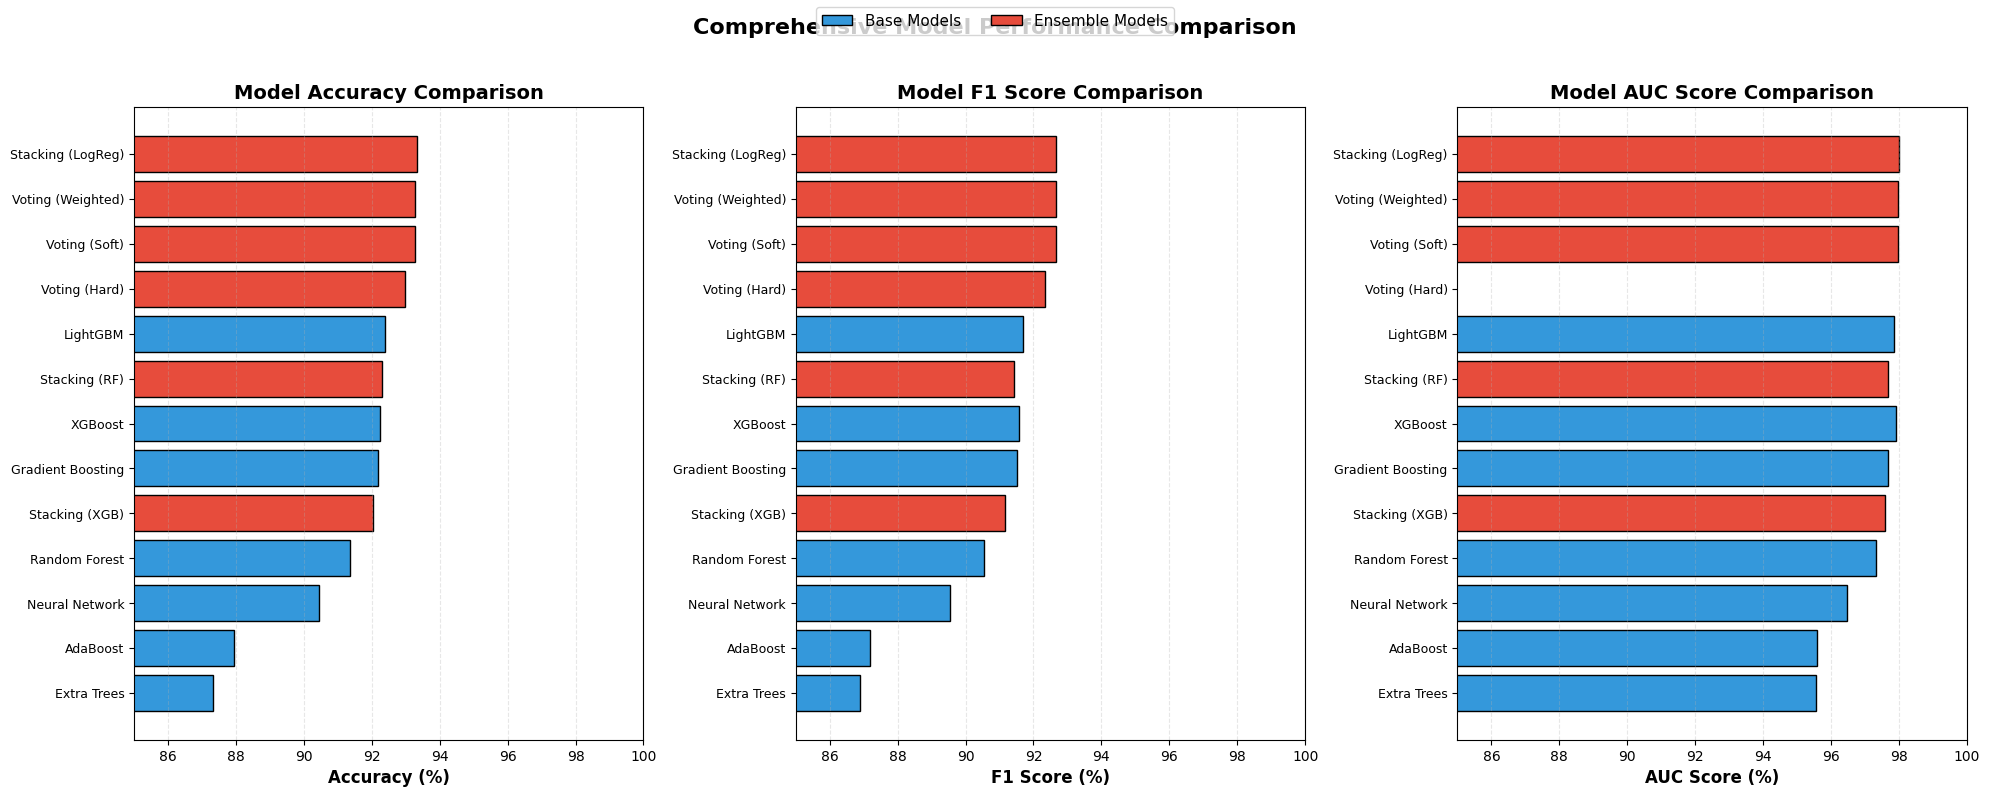


GENERATING ENSEMBLE-ONLY COMPARISON

Ensemble comparison plot saved to: ensemble_comparison.png


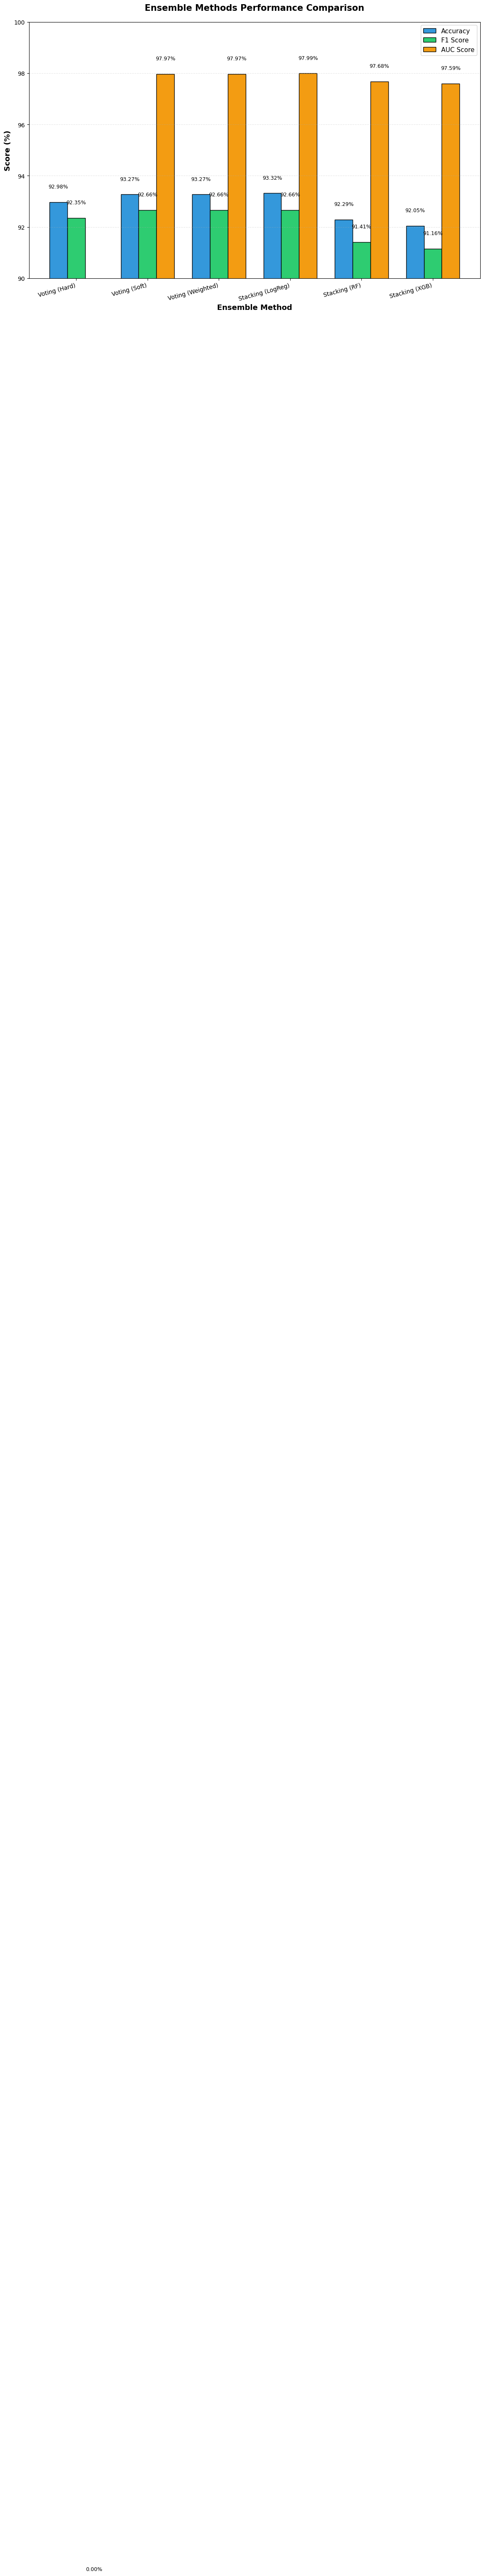


COMPREHENSIVE RESULTS SUMMARY

Rank   Model Name                          Type       Accuracy     F1           AUC         
------------------------------------------------------------------------------------------
1      Stacking (LogReg)                   ENSEMBLE        93.32%      92.66%      97.99%
2      Voting (Soft)                       ENSEMBLE        93.27%      92.66%      97.97%
3      Voting (Weighted)                   ENSEMBLE        93.27%      92.66%      97.97%
4      Voting (Hard)                       ENSEMBLE        92.98%      92.35%        N/A
5      LightGBM                            BASE            92.39%      91.70%      97.84%
6      XGBoost                             BASE            92.24%      91.57%      97.91%
7      Gradient Boosting                   BASE            92.20%      91.52%      97.68%
8      Stacking (RF)                       ENSEMBLE        92.29%      91.41%      97.68%
9      Stacking (XGB)                      ENSEMBLE        92.05%

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, f1_score
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier,
    ExtraTreesClassifier,
    BaggingClassifier,
    VotingClassifier,
    StackingClassifier
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import warnings
import joblib
warnings.filterwarnings('ignore')


class AdvancedEnsembleExoplanetClassifier:
    """
    Advanced ensemble classification system for exoplanet detection.
    Implements multiple ensemble strategies including voting, stacking, and weighted ensembles.
    """
    
    def __init__(self, train_path='data/train.csv', 
                 val_path='data/validation.csv', 
                 test_path='data/test.csv'):
        """Initialize the classifier with data paths."""
        self.train_path = train_path
        self.val_path = val_path
        self.test_path = test_path
        self.base_models = {}
        self.ensemble_models = {}
        self.all_results = {}
        self.scaler = StandardScaler()
        self.imputer = SimpleImputer(strategy='median')
        
    def load_and_preprocess_data(self):
        """Load and preprocess the train, validation, and test datasets."""
        print("="*80)
        print("LOADING AND PREPROCESSING DATA")
        print("="*80)
        
        train_df = pd.read_csv(self.train_path)
        val_df = pd.read_csv(self.val_path)
        test_df = pd.read_csv(self.test_path)
        
        print(f"\nTrain set: {train_df.shape}")
        print(f"Validation set: {val_df.shape}")
        print(f"Test set: {test_df.shape}")
        
        # Separate features and target (label column instead of koi_disposition)
        feature_cols = [col for col in train_df.columns if col != 'label']
        
        X_train = train_df[feature_cols]
        y_train = train_df['label']
        X_val = val_df[feature_cols]
        y_val = val_df['label']
        X_test = test_df[feature_cols]
        y_test = test_df['label']
        
        print(f"\nNumber of features: {len(feature_cols)}")
        print(f"\nClass distribution in training set:")
        for label, count in y_train.value_counts().items():
            label_name = "CONFIRMED" if label == 1 else "FALSE POSITIVE"
            print(f"  {label} ({label_name}): {count}")
        
        # Handle missing values and scale
        print("\nHandling missing values with median imputation...")
        X_train_imputed = self.imputer.fit_transform(X_train)
        X_val_imputed = self.imputer.transform(X_val)
        X_test_imputed = self.imputer.transform(X_test)
        
        print("Scaling features with StandardScaler...")
        X_train_scaled = self.scaler.fit_transform(X_train_imputed)
        X_val_scaled = self.scaler.transform(X_val_imputed)
        X_test_scaled = self.scaler.transform(X_test_imputed)
        
        print("\nData preprocessing completed!")
        
        return (X_train_scaled, y_train.values, 
                X_val_scaled, y_val.values,
                X_test_scaled, y_test.values)
    
    def initialize_base_models(self):
        """Initialize base classification models."""
        print("\n" + "="*80)
        print("INITIALIZING BASE MODELS")
        print("="*80)
        
        self.base_models = {
            'Random Forest': RandomForestClassifier(
                n_estimators=200,
                max_depth=15,
                min_samples_split=10,
                random_state=42,
                n_jobs=-1
            ),
            
            'XGBoost': XGBClassifier(
                n_estimators=200,
                max_depth=6,
                learning_rate=0.1,
                random_state=42,
                eval_metric='logloss',
                n_jobs=-1
            ),
            
            'LightGBM': LGBMClassifier(
                n_estimators=200,
                max_depth=6,
                learning_rate=0.1,
                random_state=42,
                verbose=-1,
                n_jobs=-1
            ),
            
            'Gradient Boosting': GradientBoostingClassifier(
                n_estimators=200,
                max_depth=5,
                learning_rate=0.1,
                random_state=42
            ),
            
            'Extra Trees': ExtraTreesClassifier(
                n_estimators=200,
                max_depth=15,
                random_state=42,
                n_jobs=-1
            ),
            
            'AdaBoost': AdaBoostClassifier(
                n_estimators=200,
                learning_rate=0.1,
                random_state=42
            ),
            
            'Neural Network': MLPClassifier(
                hidden_layer_sizes=(128, 64, 32),
                max_iter=500,
                random_state=42,
                early_stopping=True
            )
        }
        
        print(f"\nInitialized {len(self.base_models)} base models:")
        for i, name in enumerate(self.base_models.keys(), 1):
            print(f"  {i}. {name}")
    
    def train_base_models(self, X_train, y_train, X_val, y_val):
        """Train all base models and evaluate on validation set."""
        print("\n" + "="*80)
        print("TRAINING BASE MODELS")
        print("="*80)
        
        base_results = {}
        
        for name, model in self.base_models.items():
            print(f"\nTraining: {name}")
            model.fit(X_train, y_train)
            
            # Validation predictions
            y_val_pred = model.predict(X_val)
            y_val_proba = model.predict_proba(X_val)[:, 1]
            
            val_acc = accuracy_score(y_val, y_val_pred)
            val_f1 = f1_score(y_val, y_val_pred)
            val_auc = roc_auc_score(y_val, y_val_proba)
            
            base_results[name] = {
                'model': model,
                'val_accuracy': val_acc,
                'val_f1': val_f1,
                'val_auc': val_auc
            }
            
            print(f"  Validation Accuracy: {val_acc:.4f}")
            print(f"  Validation F1: {val_f1:.4f}")
            print(f"  Validation AUC: {val_auc:.4f}")
        
        return base_results
    
    def create_ensemble_models(self, base_results):
        """Create various ensemble models combining base models."""
        print("\n" + "="*80)
        print("CREATING ENSEMBLE MODELS")
        print("="*80)
        
        # Get top 5 models based on validation F1 score
        top_models = sorted(base_results.items(),
                           key=lambda x: x[1]['val_f1'],
                           reverse=True)[:5]
        
        print("\nTop 5 models selected for ensemble:")
        for i, (name, results) in enumerate(top_models, 1):
            print(f"  {i}. {name} (F1: {results['val_f1']:.4f})")
        
        # Create estimator list for ensembles
        estimators = [(name, results['model']) for name, results in top_models]
        
        # 1. Hard Voting Classifier
        self.ensemble_models['Voting (Hard)'] = VotingClassifier(
            estimators=estimators,
            voting='hard',
            n_jobs=-1
        )
        
        # 2. Soft Voting Classifier
        self.ensemble_models['Voting (Soft)'] = VotingClassifier(
            estimators=estimators,
            voting='soft',
            n_jobs=-1
        )
        
        # 3. Weighted Voting (based on validation F1 scores)
        weights = [results['val_f1'] for _, results in top_models]
        self.ensemble_models['Voting (Weighted)'] = VotingClassifier(
            estimators=estimators,
            voting='soft',
            weights=weights,
            n_jobs=-1
        )
        
        # 4. Stacking Classifier with Logistic Regression
        self.ensemble_models['Stacking (LogReg)'] = StackingClassifier(
            estimators=estimators,
            final_estimator=LogisticRegression(random_state=42, max_iter=1000),
            cv=5,
            n_jobs=-1
        )
        
        # 5. Stacking Classifier with Random Forest
        self.ensemble_models['Stacking (RF)'] = StackingClassifier(
            estimators=estimators,
            final_estimator=RandomForestClassifier(n_estimators=100, random_state=42),
            cv=5,
            n_jobs=-1
        )
        
        # 6. Stacking Classifier with XGBoost
        self.ensemble_models['Stacking (XGB)'] = StackingClassifier(
            estimators=estimators,
            final_estimator=XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss'),
            cv=5,
            n_jobs=-1
        )
        
        print(f"\nCreated {len(self.ensemble_models)} ensemble models:")
        for i, name in enumerate(self.ensemble_models.keys(), 1):
            print(f"  {i}. {name}")
    
    def train_and_evaluate_all(self, X_train, y_train, X_val, y_val, X_test, y_test):
        """Train and evaluate both base and ensemble models."""
        print("\n" + "="*80)
        print("TRAINING AND EVALUATING ALL MODELS")
        print("="*80)
        
        # Train base models first
        base_results = self.train_base_models(X_train, y_train, X_val, y_val)
        
        # Create ensemble models based on base model performance
        self.create_ensemble_models(base_results)
        
        # Evaluate base models on test set
        print("\n" + "="*80)
        print("EVALUATING BASE MODELS ON TEST SET")
        print("="*80)
        
        for name, info in base_results.items():
            model = info['model']
            y_pred = model.predict(X_test)
            y_proba = model.predict_proba(X_test)[:, 1]
            
            accuracy = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            auc = roc_auc_score(y_test, y_proba)
            
            self.all_results[f"Base: {name}"] = {
                'model': model,
                'accuracy': accuracy,
                'f1': f1,
                'auc': auc,
                'predictions': y_pred,
                'probabilities': y_proba,
                'true_labels': y_test,
                'type': 'base'
            }
            
            print(f"\n{name}:")
            print(f"  Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
            print(f"  Test F1: {f1:.4f}")
            print(f"  Test AUC: {auc:.4f}")
        
        # Train and evaluate ensemble models
        print("\n" + "="*80)
        print("TRAINING AND EVALUATING ENSEMBLE MODELS")
        print("="*80)
        
        for name, model in self.ensemble_models.items():
            print(f"\nTraining: {name}")
            model.fit(X_train, y_train)
            
            y_pred = model.predict(X_test)
            
            # Handle probability prediction based on voting type
            if 'Hard' in name:
                # For hard voting, use predictions as pseudo-probabilities
                y_proba = y_pred.astype(float)
                auc = None  # Can't calculate AUC without probabilities
            else:
                y_proba = model.predict_proba(X_test)[:, 1]
                auc = roc_auc_score(y_test, y_proba)
            
            accuracy = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            
            self.all_results[f"Ensemble: {name}"] = {
                'model': model,
                'accuracy': accuracy,
                'f1': f1,
                'auc': auc if auc is not None else 0.0,
                'predictions': y_pred,
                'probabilities': y_proba,
                'true_labels': y_test,
                'type': 'ensemble'
            }
            
            print(f"  Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
            print(f"  Test F1: {f1:.4f}")
            if auc is not None:
                print(f"  Test AUC: {auc:.4f}")
            else:
                print(f"  Test AUC: N/A (Hard Voting)")
        
        print("\n" + "="*80)
        print("ALL MODELS TRAINED AND EVALUATED")
        print("="*80)
    
    def plot_comprehensive_comparison(self, save_path='comprehensive_comparison.png'):
        """Create comprehensive comparison of all models."""
        print("\n" + "="*80)
        print("GENERATING COMPREHENSIVE COMPARISON PLOT")
        print("="*80)
        
        # Prepare data
        model_names = []
        accuracies = []
        f1_scores = []
        auc_scores = []
        model_types = []
        
        for name, result in sorted(self.all_results.items(), 
                                   key=lambda x: x[1]['accuracy']):
            model_names.append(name.replace('Base: ', '').replace('Ensemble: ', ''))
            accuracies.append(result['accuracy'] * 100)
            f1_scores.append(result['f1'] * 100)
            # Handle cases where AUC might be 0 (hard voting)
            auc_scores.append(result['auc'] * 100 if result['auc'] > 0 else 0)
            model_types.append(result['type'])
        
        # Create figure with subplots
        fig, axes = plt.subplots(1, 3, figsize=(20, 8))
        
        # Colors based on model type
        colors = ['#3498db' if t == 'base' else '#e74c3c' for t in model_types]
        
        # Plot 1: Accuracy
        bars1 = axes[0].barh(range(len(model_names)), accuracies, color=colors, edgecolor='black')
        axes[0].set_xlabel('Accuracy (%)', fontsize=12, fontweight='bold')
        axes[0].set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
        axes[0].set_yticks(range(len(model_names)))
        axes[0].set_yticklabels(model_names, fontsize=9)
        axes[0].set_xlim(85, 100)
        axes[0].grid(axis='x', alpha=0.3, linestyle='--')
        
        # Plot 2: F1 Score
        bars2 = axes[1].barh(range(len(model_names)), f1_scores, color=colors, edgecolor='black')
        axes[1].set_xlabel('F1 Score (%)', fontsize=12, fontweight='bold')
        axes[1].set_title('Model F1 Score Comparison', fontsize=14, fontweight='bold')
        axes[1].set_yticks(range(len(model_names)))
        axes[1].set_yticklabels(model_names, fontsize=9)
        axes[1].set_xlim(85, 100)
        axes[1].grid(axis='x', alpha=0.3, linestyle='--')
        
        # Plot 3: AUC Score
        bars3 = axes[2].barh(range(len(model_names)), auc_scores, color=colors, edgecolor='black')
        axes[2].set_xlabel('AUC Score (%)', fontsize=12, fontweight='bold')
        axes[2].set_title('Model AUC Score Comparison', fontsize=14, fontweight='bold')
        axes[2].set_yticks(range(len(model_names)))
        axes[2].set_yticklabels(model_names, fontsize=9)
        axes[2].set_xlim(85, 100)
        axes[2].grid(axis='x', alpha=0.3, linestyle='--')
        
        # Add legend
        from matplotlib.patches import Patch
        legend_elements = [
            Patch(facecolor='#3498db', edgecolor='black', label='Base Models'),
            Patch(facecolor='#e74c3c', edgecolor='black', label='Ensemble Models')
        ]
        fig.legend(handles=legend_elements, loc='upper center', ncol=2, fontsize=11)
        
        plt.suptitle('Comprehensive Model Performance Comparison', 
                    fontsize=16, fontweight='bold', y=0.98)
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"\nComprehensive comparison plot saved to: {save_path}")
        plt.show()
    
    def plot_ensemble_comparison(self, save_path='ensemble_comparison.png'):
        """Create detailed comparison of ensemble methods only."""
        print("\n" + "="*80)
        print("GENERATING ENSEMBLE-ONLY COMPARISON")
        print("="*80)
        
        # Filter ensemble models
        ensemble_results = {k: v for k, v in self.all_results.items() 
                          if v['type'] == 'ensemble'}
        
        model_names = [name.replace('Ensemble: ', '') for name in ensemble_results.keys()]
        metrics = {
            'Accuracy': [r['accuracy'] * 100 for r in ensemble_results.values()],
            'F1 Score': [r['f1'] * 100 for r in ensemble_results.values()],
            'AUC Score': [r['auc'] * 100 for r in ensemble_results.values()]
        }
        
        x = np.arange(len(model_names))
        width = 0.25
        
        fig, ax = plt.subplots(figsize=(14, 8))
        
        colors = ['#3498db', '#2ecc71', '#f39c12']
        for i, (metric_name, values) in enumerate(metrics.items()):
            offset = width * (i - 1)
            bars = ax.bar(x + offset, values, width, label=metric_name, 
                         color=colors[i], edgecolor='black')
            
            # Add value labels
            for bar in bars:
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                       f'{height:.2f}%', ha='center', va='bottom', fontsize=9)
        
        ax.set_xlabel('Ensemble Method', fontsize=13, fontweight='bold')
        ax.set_ylabel('Score (%)', fontsize=13, fontweight='bold')
        ax.set_title('Ensemble Methods Performance Comparison', 
                    fontsize=15, fontweight='bold', pad=20)
        ax.set_xticks(x)
        ax.set_xticklabels(model_names, rotation=15, ha='right')
        ax.set_ylim(90, 100)
        ax.legend(fontsize=11)
        ax.grid(axis='y', alpha=0.3, linestyle='--')
        
        plt.tight_layout()
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"\nEnsemble comparison plot saved to: {save_path}")
        plt.show()
    
    def print_summary_table(self):
        """Print comprehensive summary table of all results."""
        print("\n" + "="*80)
        print("COMPREHENSIVE RESULTS SUMMARY")
        print("="*80)
        
        sorted_results = sorted(self.all_results.items(), 
                               key=lambda x: x[1]['f1'], 
                               reverse=True)
        
        print(f"\n{'Rank':<6} {'Model Name':<35} {'Type':<10} {'Accuracy':<12} {'F1':<12} {'AUC':<12}")
        print("-"*90)
        
        for rank, (name, result) in enumerate(sorted_results, 1):
            model_name = name.replace('Base: ', '').replace('Ensemble: ', '')
            auc_display = f"{result['auc']*100:>10.2f}%" if result['auc'] > 0 else "       N/A"
            print(f"{rank:<6} {model_name:<35} {result['type'].upper():<10} "
                  f"{result['accuracy']*100:>10.2f}% {result['f1']*100:>10.2f}% "
                  f"{auc_display}")
        
        print("="*90)
        
        # Print best models
        best_model = sorted_results[0]
        print(f"\nBEST OVERALL MODEL: {best_model[0].replace('Base: ', '').replace('Ensemble: ', '')}")
        print(f"   Accuracy: {best_model[1]['accuracy']*100:.2f}%")
        print(f"   F1 Score: {best_model[1]['f1']*100:.2f}%")
        if best_model[1]['auc'] > 0:
            print(f"   AUC Score: {best_model[1]['auc']*100:.2f}%")
        else:
            print(f"   AUC Score: N/A")
    
    def save_best_models(self, top_n=2):
        """Save the top N best performing ensemble models."""
        # Filter only ensemble models
        ensemble_results = {k: v for k, v in self.all_results.items() 
                           if v['type'] == 'ensemble'}
        
        if not ensemble_results:
            print("\nNo ensemble models found to save!")
            return
        
        # Sort ensemble models by F1 score
        sorted_ensembles = sorted(ensemble_results.items(), 
                                 key=lambda x: x[1]['f1'], 
                                 reverse=True)
        
        # Save top N models
        saved_models = []
        for rank, (model_name, result) in enumerate(sorted_ensembles[:top_n], 1):
            # Create filename
            clean_name = model_name.replace('Ensemble: ', '').replace(' ', '_').replace('(', '').replace(')', '').lower()
            output_path = f'best_ensemble_{rank}_{clean_name}.pkl'
            
            model_package = {
                'model': result['model'],
                'scaler': self.scaler,
                'imputer': self.imputer,
                'model_name': model_name,
                'rank': rank,
                'performance': {
                    'accuracy': result['accuracy'],
                    'f1': result['f1'],
                    'auc': result['auc']
                }
            }
            
            joblib.dump(model_package, output_path)
            saved_models.append((rank, model_name, output_path, result))
            
        # Print summary
        print("\n" + "="*80)
        print(f"TOP {top_n} ENSEMBLE MODELS SAVED")
        print("="*80)
        
        for rank, model_name, path, result in saved_models:
            print(f"\nRank {rank}: {model_name.replace('Ensemble: ', '')}")
            print(f"   File: {path}")
            print(f"   Performance:")
            print(f"     - Accuracy: {result['accuracy']*100:.2f}%")
            print(f"     - F1 Score: {result['f1']*100:.2f}%")
            if result['auc'] > 0:
                print(f"     - AUC Score: {result['auc']*100:.2f}%")
            else:
                print(f"     - AUC Score: N/A")
        
        print("\n" + "="*80)
    
    def run_complete_pipeline(self):
        """Run the complete ensemble classification pipeline."""
        print("\n" + "="*80)
        print("STARTING ADVANCED ENSEMBLE EXOPLANET CLASSIFICATION PIPELINE")
        print("="*80)
        
        # Load and preprocess data
        X_train, y_train, X_val, y_val, X_test, y_test = self.load_and_preprocess_data()
        
        # Initialize base models
        self.initialize_base_models()
        
        # Train and evaluate all models
        self.train_and_evaluate_all(X_train, y_train, X_val, y_val, X_test, y_test)
        
        # Generate visualizations
        self.plot_comprehensive_comparison()
        self.plot_ensemble_comparison()
        
        # Print summary
        self.print_summary_table()
        
        # Save top 2 best ensemble models
        self.save_best_models(top_n=2)
        
        print("\n" + "="*80)
        print("PIPELINE COMPLETED SUCCESSFULLY!")
        print("="*80)
        
        return self.all_results


if __name__ == "__main__":
    # Create classifier instance
    classifier = AdvancedEnsembleExoplanetClassifier(
        train_path='data/train.csv',
        val_path='data/validation.csv',
        test_path='data/test.csv'
    )
    
    # Run complete pipeline
    results = classifier.run_complete_pipeline()
    
    print("\nAdvanced ensemble exoplanet classification complete!")
    print("Multiple ensemble strategies evaluated and compared!")